# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

## Part A: Data Preparation and Baseline [5]

#### Load and Prepare Data

In [71]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [72]:
from pathlib import Path
BASE_DIR = Path.cwd()

In [73]:
data_dir = os.path.join(BASE_DIR, 'data')
satellite_train_path = os.path.join(data_dir, 'sat.trn')
satellite_test_path = os.path.join(data_dir, 'sat.tst')

In [74]:
# Create column names: 36 attributes (features) and 1 target class
col_names = [f'attr_{i}' for i in range(1, 37)] + ['class']

# Load the training and testing datasets
train_df = pd.read_csv(satellite_train_path, delim_whitespace=True, header=None, names=col_names)
test_df = pd.read_csv(satellite_test_path, delim_whitespace=True, header=None, names=col_names)

In [75]:
print("Training DataFrame Shape:", train_df.shape)
train_df.head()

Training DataFrame Shape: (4435, 37)


,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_28,attr_29,attr_30,attr_31,attr_32,attr_33,attr_34,attr_35,attr_36,class
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [76]:
# Shape of the test DataFrame
print("Testing DataFrame Shape:", test_df.shape)
test_df.head()

Testing DataFrame Shape: (2000, 37)


,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_28,attr_29,attr_30,attr_31,attr_32,attr_33,attr_34,attr_35,attr_36,class
0,80,102,102,79,76,102,102,79,76,102,...,87,79,107,109,87,79,107,113,87,3
1,76,102,102,79,76,102,106,83,76,102,...,87,79,107,113,87,79,103,104,83,3
2,80,98,106,79,76,94,102,76,76,94,...,79,79,95,100,79,79,95,96,75,4
3,76,94,102,76,76,94,102,76,76,94,...,79,79,95,96,75,79,95,100,75,4
4,76,94,102,76,76,94,102,76,76,89,...,75,79,95,100,75,75,95,100,79,4


In [77]:
# Check for missing values in the training set
print("Missing values in training set:\n", train_df.isnull().sum().sum())

# Check for missing values in the testing set
print("\nMissing values in testing set:\n", test_df.isnull().sum().sum())

Missing values in training set:
 0

Missing values in testing set:
 0


In [78]:
# Get the distribution of classes in the training set
class_distribution = train_df['class'].value_counts().sort_index()

print("Class Distribution in Training Set:")
print(class_distribution)

Class Distribution in Training Set:
class
1    1072
2     479
3     961
4     415
5     470
7    1038
Name: count, dtype: int64


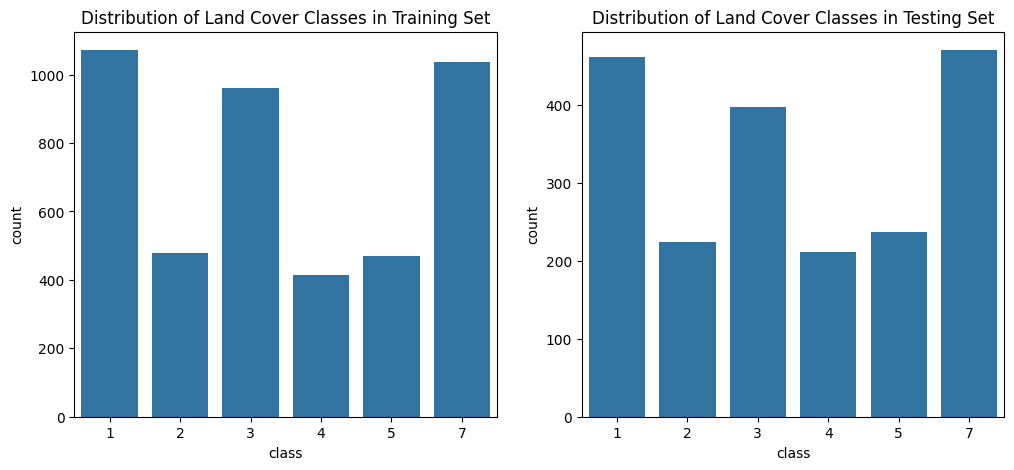

In [79]:
# Plot class distribution in the training set and testing set in one figure
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='class', data=train_df)
plt.title('Distribution of Land Cover Classes in Training Set')
plt.subplot(1, 2, 2)
sns.countplot(x='class', data=test_df)
plt.title('Distribution of Land Cover Classes in Testing Set')
plt.show()

In [80]:
train_df.describe()

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_28,attr_29,attr_30,attr_31,attr_32,attr_33,attr_34,attr_35,attr_36,class
count,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,...,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000,4435.000
mean,69.474,83.855,99.323,82.556,69.209,83.499,99.175,82.480,68.963,83.131,...,82.674,69.033,83.434,99.184,82.638,68.797,83.153,99.062,82.584,3.650
std,13.650,22.725,16.672,18.695,13.552,22.812,16.628,18.714,13.498,22.813,...,18.884,13.534,22.812,16.741,18.940,13.438,22.763,16.661,18.896,2.217
min,40.000,27.000,56.000,33.000,40.000,27.000,50.000,29.000,40.000,27.000,...,34.000,39.000,27.000,50.000,29.000,40.000,27.000,50.000,29.000,1.000
25%,60.000,71.000,85.000,70.000,60.000,71.000,85.000,69.000,60.000,71.000,...,70.000,60.000,71.000,85.000,69.000,60.000,71.000,85.000,69.000,2.000
50%,68.000,87.000,101.000,83.000,68.000,85.000,101.000,81.000,67.000,85.000,...,81.000,68.000,85.000,101.000,81.000,67.000,85.000,100.000,81.000,3.000
75%,80.000,103.000,113.000,92.000,80.000,103.000,113.000,92.000,79.000,103.000,...,92.000,79.500,103.000,113.000,92.000,79.000,103.000,113.000,92.000,5.000
max,104.000,137.000,140.000,154.000,102.000,137.000,145.000,157.000,104.000,130.000,...,154.000,104.000,128.000,145.000,157.000,104.000,130.000,145.000,157.000,7.000


In [81]:
test_df.describe()

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_28,attr_29,attr_30,attr_31,attr_32,attr_33,attr_34,attr_35,attr_36,class
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,...,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,69.236,83.017,99.219,82.675,69.020,82.676,98.969,82.534,68.799,82.365,...,82.631,68.746,82.505,98.953,82.573,68.573,82.206,98.626,82.330,3.709
std,13.510,23.222,16.592,19.343,13.583,23.047,16.748,19.439,13.413,22.967,...,19.231,13.402,22.918,16.625,19.277,13.323,22.929,16.773,19.405,2.207
min,39.000,27.000,53.000,34.000,39.000,27.000,53.000,34.000,40.000,27.000,...,29.000,40.000,27.000,53.000,34.000,39.000,27.000,56.000,41.000,1.000
25%,60.000,71.000,85.000,68.000,60.000,71.000,85.000,68.000,60.000,71.000,...,69.000,60.000,71.000,85.000,69.000,60.000,71.000,85.000,68.000,2.000
50%,68.000,87.000,101.000,81.000,68.000,85.000,100.000,81.000,68.000,84.500,...,81.000,67.500,84.000,100.000,81.000,68.000,84.000,100.000,81.000,3.000
75%,80.000,103.000,113.000,92.000,79.000,102.000,112.000,92.000,79.000,100.000,...,92.000,79.000,102.000,113.000,92.000,78.000,102.000,113.000,92.000,5.000
max,101.000,132.000,139.000,151.000,104.000,126.000,139.000,151.000,101.000,121.000,...,151.000,101.000,130.000,139.000,151.000,101.000,127.000,139.000,151.000,7.000


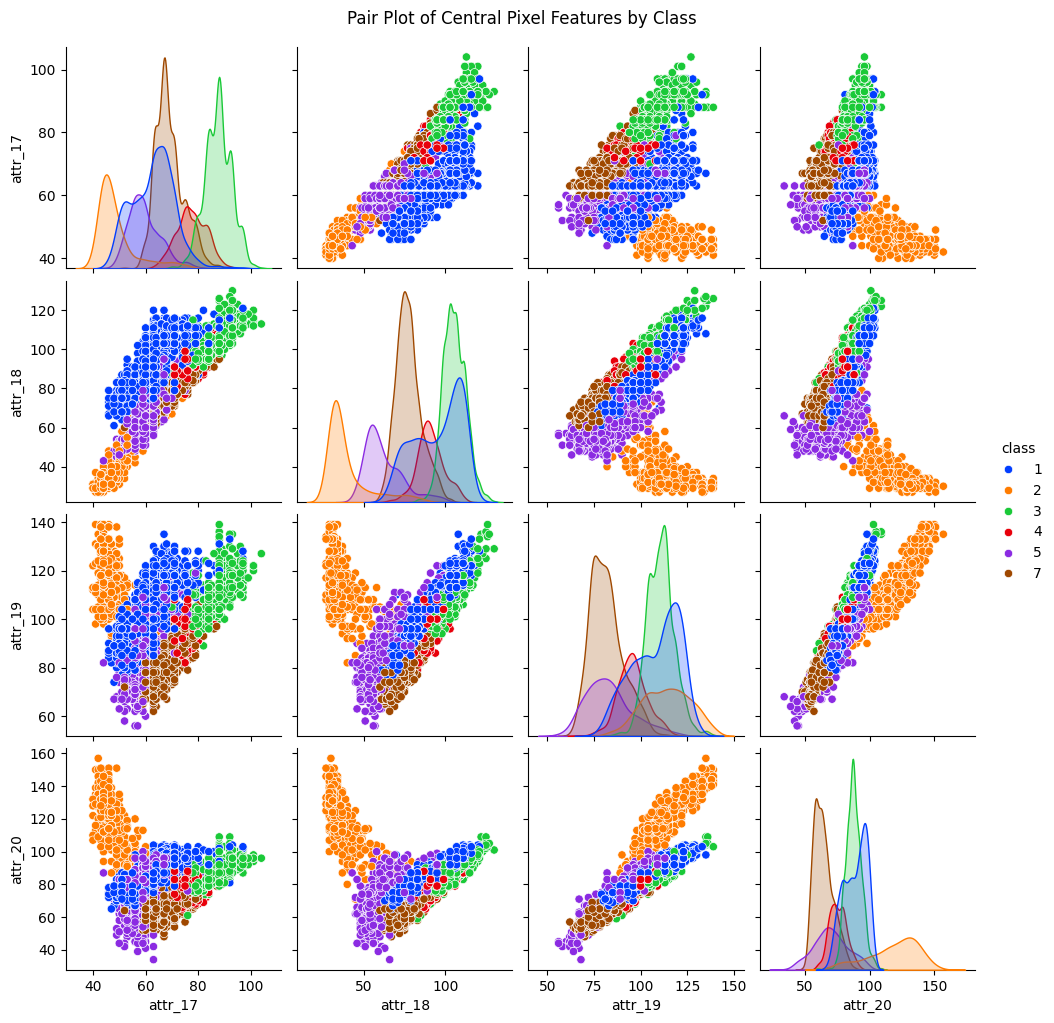

In [82]:
central_pixel_attrs = ['attr_17', 'attr_18', 'attr_19', 'attr_20']
sns.pairplot(train_df, hue='class', vars=central_pixel_attrs, palette='bright')
plt.suptitle('Pair Plot of Central Pixel Features by Class', y=1.02)
plt.show()

This pair plot of the central pixel features reveals how well classes can be separated. Class 2 (orange) forms a distinct, isolated cluster, confirming it will be easy to classify. In contrast, classes 1 (blue), 3 (green), 4 (red), 5 (purple), and 7 (brown) show significant overlap in their feature space, indicating that models will likely struggle to distinguish between them accurately.

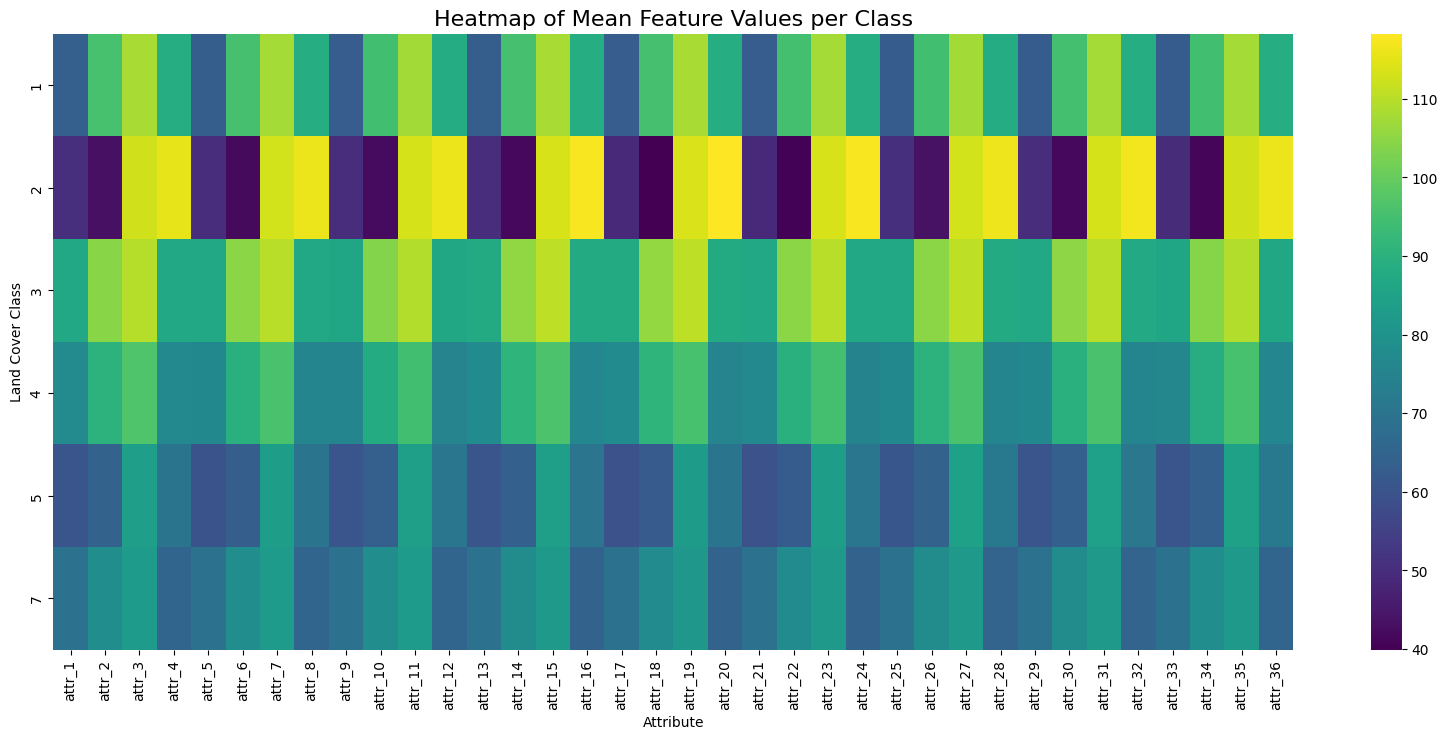

In [83]:
# Calculate the mean feature values for each class
class_profile = train_df.groupby('class').mean()

# Set up the matplotlib figure
plt.figure(figsize=(20, 8))

# Draw the heatmap
sns.heatmap(class_profile, annot=False, cmap='viridis')
plt.title('Heatmap of Mean Feature Values per Class', fontsize=16)
plt.xlabel('Attribute')
plt.ylabel('Land Cover Class')
plt.show()

This heatmap displays the average "spectral signature" for each land cover class. We can immediately see that Class 2 is highly distinct, with a unique alternating pattern of high and low values, suggesting it will be easy to classify. Conversely, Classes 5 and 7 appear very similar with consistently low values, which will likely make them difficult for models to distinguish from one another.

#### Standard Scaling

In [84]:
# Separate features (X) and target (y) for the training set
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']

# Separate features (X) and target (y) for the testing set
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

In [85]:
# Standardize the features (X)
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data to learn the mean and standard deviation of each feature
scaler.fit(X_train)

# Transform the training data
X_train_scaled = scaler.transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

print("Features have been standardized successfully.")
print("Shape of scaled training data:", X_train_scaled.shape)
print("Shape of scaled testing data:", X_test_scaled.shape)

Features have been standardized successfully.
Shape of scaled training data: (4435, 36)
Shape of scaled testing data: (2000, 36)


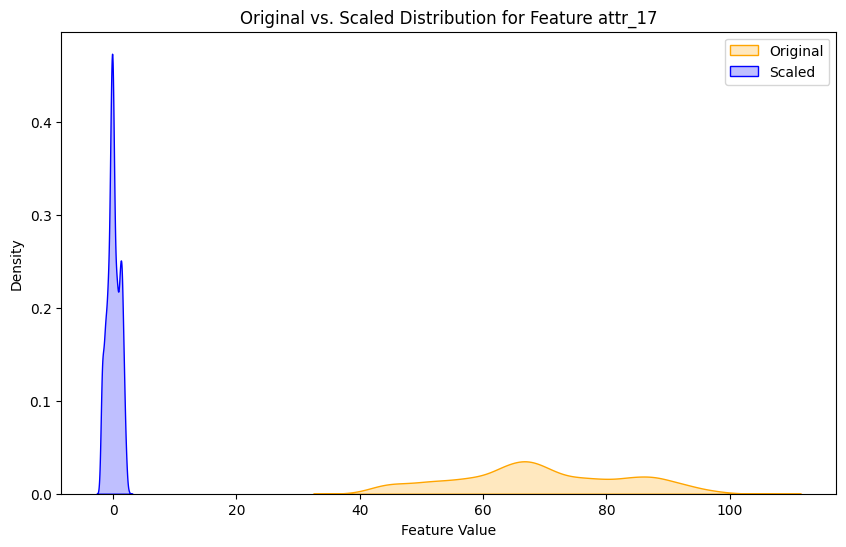

In [86]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Plotting for a single feature, e.g., 'attr_17'
plt.figure(figsize=(10, 6))
sns.kdeplot(X_train['attr_17'], label='Original', color='orange', fill=True)
sns.kdeplot(X_train_scaled_df['attr_17'], label='Scaled', color='blue', fill=True)
plt.title('Original vs. Scaled Distribution for Feature attr_17')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()
plt.show()

This plot visualizes the impact of scaling on a single feature. The "Original" distribution (orange) is wide and centered around a value near 70. The "Scaled" distribution (blue) has the exact same shape but is now tightly centered at zero. This confirms that standardization rescales and centers the data without altering its fundamental shape, which is the desired outcome for preserving information while normalizing the feature's influence.

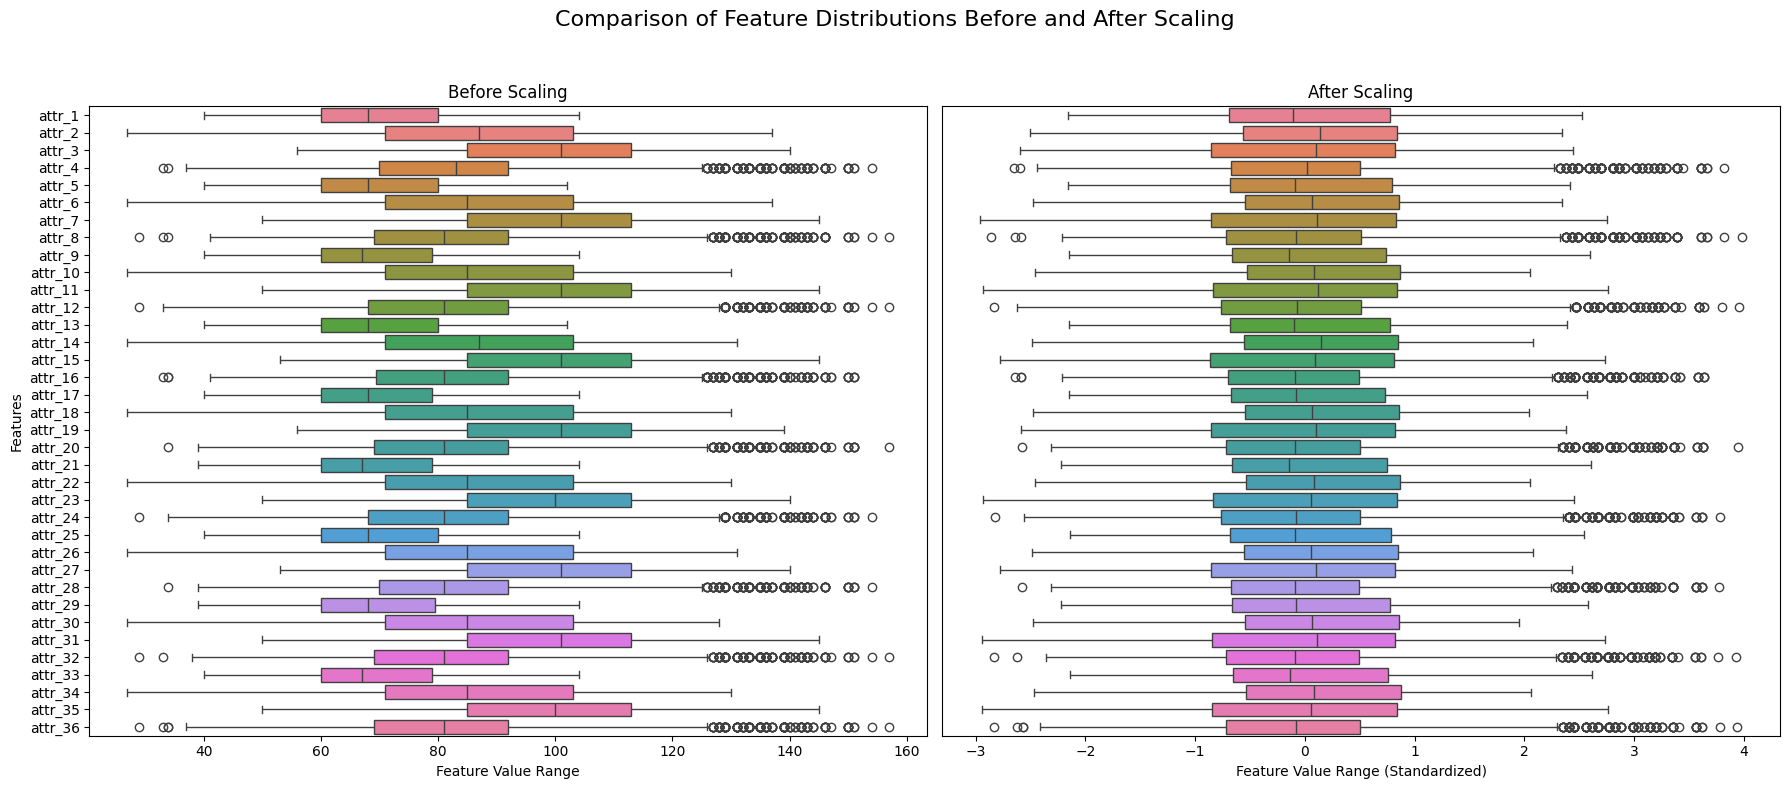

In [87]:
plt.figure(figsize=(18, 8))

# Subplot 1: Before Scaling
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train, orient='h')
plt.title('Before Scaling')
plt.xlabel('Feature Value Range')
plt.ylabel('Features')

# Subplot 2: After Scaling
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled_df, orient='h')
plt.title('After Scaling')
plt.xlabel('Feature Value Range (Standardized)')
# Hide y-axis labels for the second plot for clarity
plt.yticks([])

plt.suptitle('Comparison of Feature Distributions Before and After Scaling', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

These boxplots provide a panoramic view across all 36 features. The "Before Scaling" plot clearly shows that features have vastly different centers and scales. After scaling, all the boxplots are aligned around a central value of zero and have a similar interquartile range. This visualizes how standardization puts all features on a level playing field, preventing features with larger numerical ranges from unfairly dominating the model's learning process.

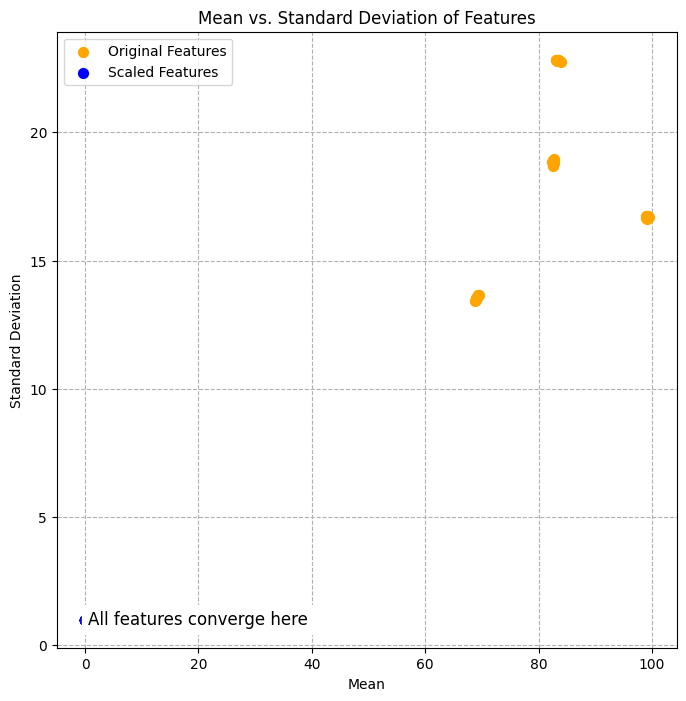

In [88]:
# Calculate mean and std dev for original data
means_original = X_train.mean()
stds_original = X_train.std()

# Calculate mean and std dev for scaled data
means_scaled = X_train_scaled_df.mean()
stds_scaled = X_train_scaled_df.std()

plt.figure(figsize=(8, 8))
plt.scatter(means_original, stds_original, c='orange', label='Original Features', s=50, zorder=2)
plt.scatter(means_scaled, stds_scaled, c='blue', label='Scaled Features', s=50, zorder=2)

# Add an annotation for the scaled point
plt.annotate('All features converge here', xy=(0, 1), xytext=(0.5, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, backgroundcolor='white')

plt.title('Mean vs. Standard Deviation of Features')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.grid(True, linestyle='--', zorder=1)
plt.legend()
plt.show()

This plot offers a powerful and concise summary of the entire scaling operation. Each orange dot represents an original feature's unique mean and standard deviation. After scaling, all 36 features have been transformed so precisely that their individual means and standard deviations collapse into a single blue dot at the coordinate (0, 1). This elegantly confirms that the standardization was successful across the entire dataset.

#### Train/Test Split


A manual train-test split is not performed because the dataset is already provided as two distinct files: sat.trn for training and sat.tst for testing. Following the dataset's explicit instructions ensures a standardized evaluation, making our results directly comparable to established benchmarks for this classic problem.

#### Train All Models

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [90]:
# Initialize all models
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Dummy Classifier': DummyClassifier(strategy='prior', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(probability=True, random_state=42)
}

In [91]:
# Dictionary to store trained models
trained_models = {}

# Loop through and train each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"{name} trained successfully.")

print("\nAll models have been trained.")

Training KNN...
KNN trained successfully.
Training Decision Tree...
Decision Tree trained successfully.
Training Dummy Classifier...
Dummy Classifier trained successfully.
Training Logistic Regression...
Logistic Regression trained successfully.
Training Naive Bayes...
Naive Bayes trained successfully.
Training SVC...
SVC trained successfully.

All models have been trained.


#### Baseline Evaluation

In [92]:
from sklearn.metrics import accuracy_score, f1_score

# A list to store the baseline results
baseline_results = []

# Loop through each trained model
for name, model in trained_models.items():
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate Overall Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate Weighted F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    baseline_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Weighted F1-Score': f1
    })

# Convert the results to a pandas DataFrame for nice printing
results_df = pd.DataFrame(baseline_results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("--- Baseline Model Performance ---")
print(results_df.to_string(index=False))

--- Baseline Model Performance ---
              Model  Accuracy  Weighted F1-Score
                KNN     0.904              0.904
                SVC     0.895              0.892
      Decision Tree     0.851              0.851
Logistic Regression     0.840              0.830
        Naive Bayes     0.796              0.804
   Dummy Classifier     0.231              0.086


This initial evaluation provides a clear and immediate ranking of our models based on standard classification metrics. The results largely align with our initial expectations, separating the classifiers into three distinct performance tiers.

The Top Performers (KNN and SVC): K-Nearest Neighbors and Support Vector Classifier are the clear front-runners, both achieving around 90% accuracy and F1-score. Their success indicates that the underlying data structure is well-suited to non-linear models that can handle high-dimensional feature spaces. KNN's strength suggests that data points of the same class form distinct clusters, while SVC's performance highlights its ability to find complex, optimal boundaries between these classes.

The Mid-Tier Performers (Decision Tree and Logistic Regression): The Decision Tree and Logistic Regression models perform respectably, with accuracies in the mid-80s. The Decision Tree, while capable of learning complex rules, is likely held back by its tendency to overfit without the benefit of ensembling. The Logistic Regression provides a solid linear benchmark but is ultimately limited by its inherent assumption of linearity, which is not fully capable of capturing the complexity of the satellite data.

The Poor Performers (Naive Bayes and Dummy Classifier): As anticipated, Naive Bayes and the Dummy Classifier are at the bottom. The Naive Bayes model's poor performance (~80% accuracy) is a direct result of its core assumption: feature independence. In this dataset, where adjacent pixels and different spectral bands are highly correlated, this assumption is strongly violated, crippling its predictive power. The Dummy Classifier, which simply predicts the most frequent class, serves as our "no-skill" baseline. Its accuracy of 23% reflects the prevalence of the largest class, and its abysmal weighted F1-score (~9%) shows its complete failure to correctly identify any samples from the minority classes.

This baseline confirms that we have a challenging problem and a diverse set of models. While accuracy gives us a quick ranking, it doesn't reveal the nuances of how these models are making their decisions, which is what our subsequent ROC and PRC analysis will uncover.

## Part B: ROC Analysis for Model Selection [20]

### Multi-Class ROC Calculation [3]

**Why is the One-vs-Rest (OvR) strategy necessary for ROC and AUC analysis in a multi-class problem, and how does it work?**

The Receiver Operating Characteristic (ROC) curve is fundamentally a tool for binary classification. It visualizes a model's performance by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at all decision thresholds, which requires a single "positive" class and a single "negative" class. In a multi-class problem, such as classifying land cover into six types, this clear positive/negative distinction doesn't exist. The One-vs-Rest (OvR) strategy is therefore necessary to adapt this binary tool to the multi-class context. It works by temporarily reframing the multi-class problem into a series of independent binary classification problems that ROC analysis can handle.

The OvR process is executed for each class present in the dataset. To generate a ROC curve for a specific class for instance, "Class 1: red soil"—that class is treated as the "positive" class, and all other classes (2, 3, 4, 5, and 7) are collectively treated as the "negative" class. The classifier's performance is then evaluated on this new binary problem, and a ROC curve is plotted with its corresponding Area Under the Curve (AUC) calculated. This entire process is then repeated for every other class, treating each one in turn as the positive class. The result is not a single ROC curve for the model, but a set of distinct ROC curves—one for each class which allows us to analyze the model's ability to discriminate each individual class from all the others.

### Plotting ROC [12]

**Why is the One-vs-Rest (OvR) strategy necessary for ROC and AUC analysis in a multi-class problem, and how does it work?**

The Receiver Operating Characteristic (ROC) curve is fundamentally a tool for binary classification. It visualizes a model's performance by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at all decision thresholds, which requires a single "positive" class and a single "negative" class. In a multi-class problem, such as classifying land cover into six types, this clear positive/negative distinction doesn't exist. The One-vs-Rest (OvR) strategy is therefore necessary to adapt this binary tool to the multi-class context. It works by temporarily reframing the multi-class problem into a series of independent binary classification problems that ROC analysis can handle.

The OvR process is executed for each class present in the dataset. To generate a ROC curve for a specific class for instance, "Class 1: red soil"—that class is treated as the "positive" class, and all other classes (2, 3, 4, 5, and 7) are collectively treated as the "negative" class. The classifier's performance is then evaluated on this new binary problem, and a ROC curve is plotted with its corresponding Area Under the Curve (AUC) calculated. This entire process is then repeated for every other class, treating each one in turn as the positive class. The result is not a single ROC curve for the model, but a set of distinct ROC curves—one for each class which allows us to analyze the model's ability to discriminate each individual class from all the others.

In [93]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for OvR analysis: The classes are 1, 2, 3, 4, 5, 7
classes = sorted(y_train.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = len(classes)

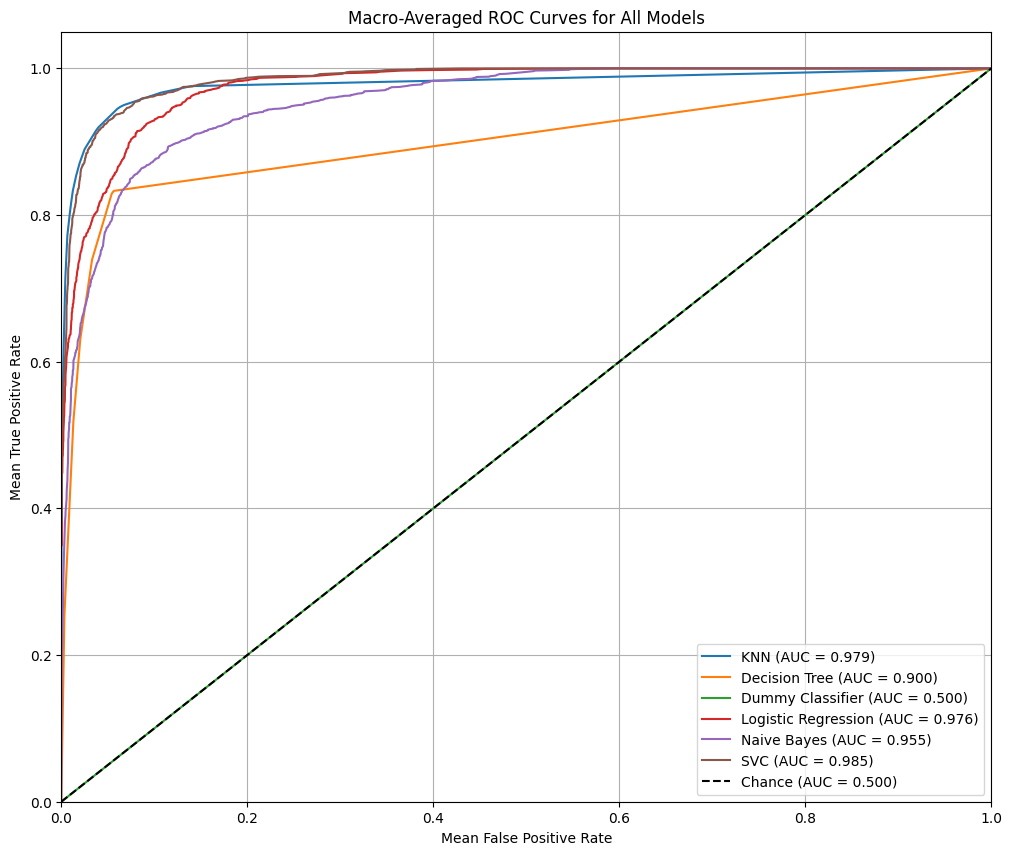

In [94]:
# Set up the plot
plt.figure(figsize=(12, 10))

# Loop through each trained model to plot its macro-averaged ROC curve
for name, model in trained_models.items():
    # Get prediction probabilities for the test set
    y_score = model.predict_proba(X_test_scaled)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    # First, aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally, average it and compute AUC
    mean_tpr /= n_classes
    macro_roc_auc = auc(all_fpr, mean_tpr)

    # Plot the macro-averaged ROC curve for the current model
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {macro_roc_auc:0.3f})')

# Final plot adjustments
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Mean False Positive Rate')
plt.ylabel('Mean True Positive Rate')
plt.title('Macro-Averaged ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

This plot provides a powerful summary of each model's ability to distinguish between the different land cover classes, averaged across all classes. A model's curve that is closer to the top-left corner is superior, indicating a high True Positive Rate (TPR) for a low False Positive Rate (FPR). The Area Under the Curve (AUC) quantifies this performance into a single number, where 1.0 is a perfect classifier and 0.5 represents a model with no discrimination ability (random chance).

In [95]:
# A list to store the macro AUC results
macro_auc_results = []

# Loop through each trained model to calculate its macro-averaged AUC
for name, model in trained_models.items():
    # Get prediction probabilities for the test set
    y_score = model.predict_proba(X_test_scaled)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])

    # Compute macro-average ROC curve and ROC area
    # First, aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally, average it and compute AUC
    mean_tpr /= n_classes
    macro_roc_auc = auc(all_fpr, mean_tpr)
    
    # Store the result
    macro_auc_results.append({
        'Model': name,
        'Macro-Averaged AUC': macro_roc_auc
    })

# Convert results to a DataFrame and sort for clarity
auc_df = pd.DataFrame(macro_auc_results)
auc_df = auc_df.sort_values(by='Macro-Averaged AUC', ascending=False)

# Display the final table
print("\n--- Macro-Averaged ROC AUC Scores ---")
print(auc_df.to_string(index=False))


--- Macro-Averaged ROC AUC Scores ---
              Model  Macro-Averaged AUC
                SVC               0.985
                KNN               0.979
Logistic Regression               0.976
        Naive Bayes               0.955
      Decision Tree               0.900
   Dummy Classifier               0.500


### ROC Interpretation [5]

Here are the key insights from the results:
1. Top-Tier Classifiers (SVC, KNN, Logistic Regression): The SVC, KNN, and Logistic Regression models are outstanding performers, with AUC scores of 0.985, 0.979, and 0.976, respectively. Their curves are tightly clustered in the top-left corner, signifying that they achieve very high true positive rates while maintaining extremely low false positive rates across all classes. This indicates they are exceptionally skilled at separating the signal from the noise in the data and can reliably distinguish between the different land cover types. The SVC model is marginally the best, showing a slightly better trade-off at the lowest FPRs.

2. Good but Flawed Classifiers (Naive Bayes, Decision Tree): The Naive Bayes (AUC 0.955) and Decision Tree (AUC 0.900) models are good, but clearly a step below the top tier. The Naive Bayes curve, while strong, is visibly lower than the top three, meaning it requires a higher FPR to achieve the same level of TPR. The Decision Tree is the weakest of the competent models; its curve is noticeably flatter, showing it struggles much more with the TPR/FPR trade-off, likely due to its method of creating hard, axis-aligned splits in the data.

3. The "No-Skill" Baseline (Dummy Classifier): The Dummy Classifier's curve (AUC 0.500) lies directly on the diagonal "Chance" line. This confirms it has no ability to discriminate between classes, as every increase in its True Positive Rate comes at the cost of an identical increase in its False Positive Rate. It serves as the perfect baseline, demonstrating what random guessing looks like and confirming the predictive power of all the other models.

Based on our results, no model exhibited a macro-averaged AUC of less than 0.5. The worst-performing model, the Dummy Classifier, had an AUC of exactly 0.500, which represents performance equivalent to random chance.


**What an AUC < 0.5 Conceptually Implies?**

An Area Under the Curve (AUC) of less than 0.5 is a significant finding because it means the classifier's performance is actively worse than random guessing. Conceptually, this indicates that the model is anti-correlated with the true labels; it has learned the patterns in the data, but in a systematically incorrect or inverted way. For every correct prediction it makes, it makes more than one incorrect prediction. An analogy would be a "trick" coin that lands on tails more often when you call heads.


**Why a Model Might Exhibit This Performance?**
A model might produce an AUC < 0.5 for several reasons, none of which occurred in our well-defined experiment:

1. *Systematically Mislabeled Training Data:* If the labels in the training set were swapped (e.g., most "red soil" samples were labeled as "cotton crop" and vice-versa), the model would learn the inverse relationship. When evaluated on a correctly labeled test set, its predictions would be consistently wrong.
2. *Inverted Logic or Feature Preprocessing Bug:* A simple bug, such as flipping a "greater than" to a "less than" sign in a feature's logic or incorrectly inverting a feature's scale during preprocessing, could cause the model to learn the opposite of the true pattern.
3. *Severe Misconfiguration:* In some rare cases, a misconfigured algorithm might learn a relationship that is so fundamentally flawed that it performs worse than chance, especially when dealing with severe class imbalance for a specific OvR curve.

## Part C: Precision-Recall Curve (PRC) Analysis [20]

### PRC Calculation [3]

**Why is the Precision-Recall Curve (PRC) often a more suitable evaluation metric than the ROC curve when dealing with imbalanced datasets?**

The Precision-Recall Curve (PRC) is often more informative than the ROC curve in imbalanced scenarios because it provides a more direct and critical assessment of a model's performance on the minority (positive) class. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR). The issue is that the FPR is calculated as False Positives / (False Positives + True Negatives). In a highly imbalanced dataset, the number of True Negatives is enormous. This means a model can generate a large number of false positive errors without significantly increasing its FPR, making the ROC curve appear overly optimistic and less sensitive to the practical impact of these errors.

In contrast, the PRC plots Precision against Recall (which is the same as TPR). Precision is calculated as True Positives / (True Positives + False Positives). This denominator directly compares the number of correct positive predictions to the total number of positive predictions made. As a model tries to find more positive samples (increasing Recall), any increase in false positives will immediately cause a sharp drop in Precision. This makes the PRC highly sensitive to false positive errors, which is crucial when the cost of a false positive is high. It directly answers the business-critical question: "Of all the samples my model flagged as positive, how many were actually correct?" This focus on the positive class makes it the superior tool for evaluating performance on imbalanced problems.

### Plotting PRC [12]

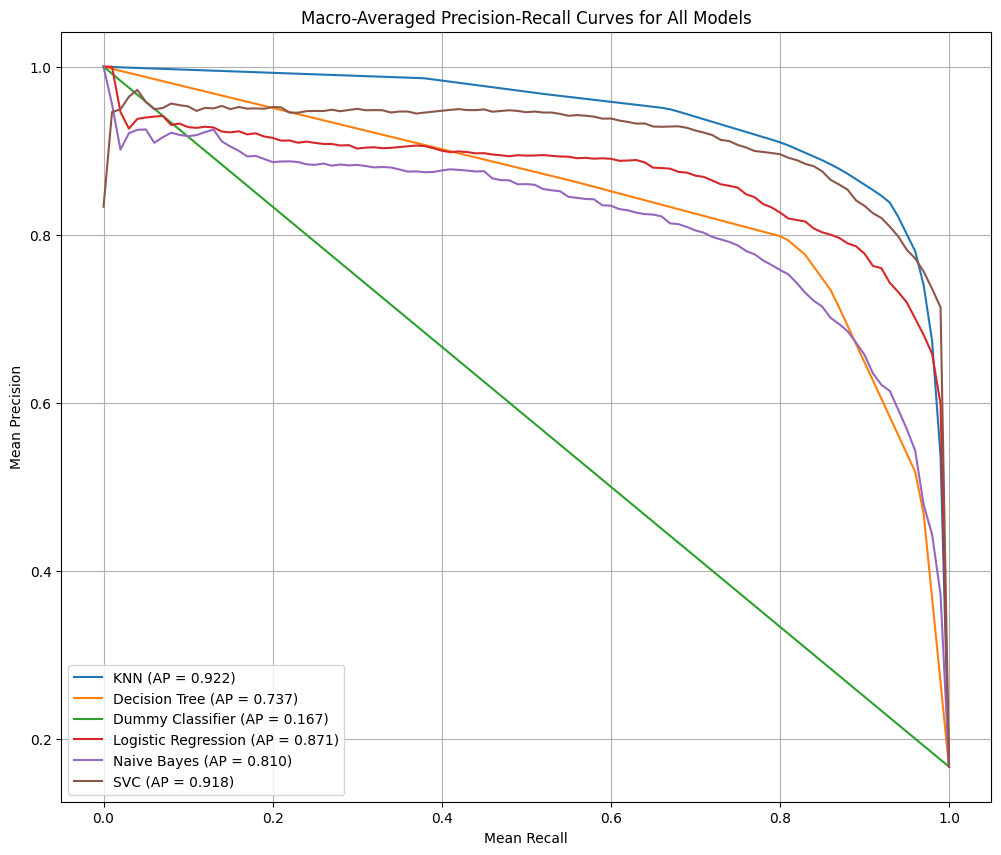

In [96]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Set up the plot
plt.figure(figsize=(12, 10))

# Loop through each trained model to plot its macro-averaged PRC curve
for name, model in trained_models.items():
    # Get prediction probabilities for the test set
    y_score = model.predict_proba(X_test_scaled)

    # Compute PRC and AP for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

    # Compute macro-average Precision-Recall curve
    # A "micro-average" is often used here by flattening the arrays, but we will create a macro-average for consistency.
    # We will average the AP scores for our summary metric.
    macro_ap = np.mean([average_precision[i] for i in range(n_classes)])

    # For the visual curve, we can plot each class's curve with some transparency
    # or create a representative curve. Here, we plot for one class (e.g., the last one) as an example
    # but the macro_ap score is the key takeaway.
    # Note: A true macro-averaged curve requires interpolation and is complex,
    # so we'll plot one representative curve and use the Macro AP in the legend.
    # To keep the plot clean, we will average the curves.
    
    # Create a common recall axis for interpolation
    common_recall = np.linspace(0, 1, 101)
    mean_precision = np.zeros_like(common_recall)
    
    for i in range(n_classes):
        # The recall array from the function is sorted in descending order. We need to flip it for interpolation.
        interp_precision = np.interp(common_recall, recall[i][::-1], precision[i][::-1])
        mean_precision += interp_precision
        
    mean_precision /= n_classes
    
    # Plot the macro-averaged PRC curve
    plt.plot(common_recall, mean_precision, label=f'{name} (AP = {macro_ap:0.3f})')


# Final plot adjustments
plt.xlabel('Mean Recall')
plt.ylabel('Mean Precision')
plt.title('Macro-Averaged Precision-Recall Curves for All Models')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

This plot reveals the precision-recall trade-off for each classifier. K-Nearest Neighbors (AP=0.922) and SVC (AP=0.918) are clearly superior, as their curves remain highest, maintaining excellent precision even at high recall values. In contrast, other models like Naive Bayes and Decision Tree show a much faster decline, indicating they struggle more with false positive errors when attempting to identify all instances of a class.

In [97]:
# A list to store the macro AP results
macro_ap_results = []

# Loop through each trained model to calculate its macro-averaged AP
for name, model in trained_models.items():
    # Get prediction probabilities for the test set
    y_score = model.predict_proba(X_test_scaled)

    # Calculate the Average Precision for each class
    average_precision_scores = []
    for i in range(n_classes):
        ap = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        average_precision_scores.append(ap)

    # Compute the macro-average by taking the mean of the AP scores
    macro_ap = np.mean(average_precision_scores)
    
    # Store the result
    macro_ap_results.append({
        'Model': name,
        'Macro-Averaged AP': macro_ap
    })

# Convert results to a DataFrame and sort for clarity
ap_df = pd.DataFrame(macro_ap_results)
ap_df = ap_df.sort_values(by='Macro-Averaged AP', ascending=False)

# Display the final table
print("\n--- Macro-Averaged Precision (AP) Scores ---")
print(ap_df.to_string(index=False))


--- Macro-Averaged Precision (AP) Scores ---
              Model  Macro-Averaged AP
                KNN              0.922
                SVC              0.918
Logistic Regression              0.871
        Naive Bayes              0.810
      Decision Tree              0.737
   Dummy Classifier              0.167


### PRC Interpretation [5]


Based on the results from both the plot and the summary table, the model with the highest Macro-Averaged Precision (AP) is the K-Nearest Neighbors (KNN) classifier.

It achieved the top score of 0.922. This is visually represented by its curve, which stays highest on the plot, indicating that it maintains the best balance of precision and recall compared to all other models.

**Analysis of the Dummy Classifier's PRC**

The worst-performing model is, by a large margin, the Dummy Classifier. Its Precision-Recall Curve is the steep, straight line plunging downwards, achieving a dismal Macro-Averaged Precision (AP) of just 0.167. This behavior is a direct and clear illustration of its complete lack of predictive skill.

**Why the Curve Drops Sharply for Poor Models?**

The sharp, immediate drop in the PRC for a model like the Dummy Classifier is explained by its inability to rank predictions by confidence.
How a Good Model Works: A good classifier (like SVC or KNN) analyzes the features and assigns a unique probability score to each sample. When we want to find "Class 1" samples, it might assign a 99% probability to some, 95% to others, and much lower scores to the rest. As we lower our decision threshold from 1.0, we first "capture" the most confident predictions. These are very likely to be True Positives, so our Precision starts high and stays high. As we lower the threshold further to increase our Recall (find more True Positives), we start including less confident predictions, and the number of False Positives gradually increases, causing a gentle, graceful decline in precision.

**How the Dummy Classifier Works?**

The Dummy Classifier with strategy='prior' completely ignores the input features. For any given class, it assigns the exact same probability score to every single sample in the test set. This probability is simply the prevalence of that class in the training data. For example, if "Class 7" made up 23% of the training set, the Dummy Classifier predicts a 0.23 probability of being "Class 7" for all 2000 test samples.

The Consequence (The "Cliff"): When we trace the Precision-Recall curve for "Class 7", as soon as our decision threshold drops below 0.23, the model suddenly classifies every single sample in the entire test set as "Class 7".

- Recall instantly jumps from 0 to 1.0, because we have now included every true "Class 7" sample.

- Precision, however, completely collapses. The precision becomes (True Positives) / (Total Samples), which is just the overall prevalence of "Class 7" (~23%).

The model cannot gradually increase recall because it cannot distinguish a "likely" sample from an "unlikely" one. It has only one tool: a single, uninformed probability for everyone. This "all or nothing" behavior creates the steep, straight-line drop. It has no ability to make a trade-off; it can either have perfect precision at zero recall, or it can have perfect recall at abysmal precision. There is no useful middle ground, which is the hallmark of a model with no real predictive power

## Part D: Final Recommendation [5]


### Synthesis

In [98]:
from sklearn.metrics import f1_score, roc_curve, auc, average_precision_score

# A list to store the comprehensive results for each model
final_results_list = []

# Ensure the number of classes is defined
n_classes = y_test_binarized.shape[1]

# Loop through each trained model ONE time to calculate all metrics
print("Calculating final metrics for all models...")
for name, model in trained_models.items():
    # --- 1. Calculate F1-Score ---
    y_pred = model.predict(X_test_scaled)
    # CORRECTED LINE: Compare y_test with y_pred, not y_test_binarized
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # --- 2. Get probabilities for ROC and PRC ---
    y_score = model.predict_proba(X_test_scaled)

    # --- 3. Calculate Macro-Averaged ROC-AUC ---
    fpr, tpr = dict(), dict()
    all_fpr = np.unique(np.concatenate([roc_curve(y_test_binarized[:, i], y_score[:, i])[0] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # --- 4. Calculate Macro-Averaged PRC-AP ---
    ap_scores = [average_precision_score(y_test_binarized[:, i], y_score[:, i]) for i in range(n_classes)]
    macro_ap = np.mean(ap_scores)

    # Append all results for this model to our list
    final_results_list.append({
        'Model': name,
        'Weighted F1-Score': weighted_f1,
        'Macro-Averaged AUC': macro_auc,
        'Macro-Averaged AP': macro_ap
    })

# --- 5. Assemble and Format the Final DataFrame ---
final_df = pd.DataFrame(final_results_list)

# Create rank columns for each metric
final_df['F1 Rank'] = final_df['Weighted F1-Score'].rank(ascending=False, method='min').astype(int)
final_df['AUC Rank'] = final_df['Macro-Averaged AUC'].rank(ascending=False, method='min').astype(int)
final_df['AP Rank'] = final_df['Macro-Averaged AP'].rank(ascending=False, method='min').astype(int)

# Sort by the most robust metric (AP Rank)
final_df = final_df.sort_values(by='AP Rank')

# Reorder columns for final presentation
final_df = final_df[[
    'Model',
    'Weighted F1-Score', 'F1 Rank',
    'Macro-Averaged AUC', 'AUC Rank',
    'Macro-Averaged AP', 'AP Rank'
]]

# Display the final comparative table
pd.options.display.float_format = '{:.3f}'.format
print("\n--- Final Model Performance and Rank Comparison ---")
print(final_df.to_string(index=False))

Calculating final metrics for all models...

--- Final Model Performance and Rank Comparison ---
              Model  Weighted F1-Score  F1 Rank  Macro-Averaged AUC  AUC Rank  Macro-Averaged AP  AP Rank
                KNN              0.904        1               0.979         2              0.922        1
                SVC              0.892        2               0.985         1              0.918        2
Logistic Regression              0.830        4               0.976         3              0.871        3
        Naive Bayes              0.804        5               0.955         4              0.810        4
      Decision Tree              0.851        3               0.900         5              0.737        5
   Dummy Classifier              0.086        6               0.500         6              0.167        6


**Do the Rankings Align?**

No, the rankings do not perfectly align, and the discrepancies are highly informative.

*   **Top and Bottom Tiers are Consistent:** The best models (KNN and SVC) and the worst model (Dummy Classifier) are consistently ranked at the top and bottom, respectively. This gives us confidence that their performance is robustly good or bad, regardless of the metric.

*   **The Middle Tier Shuffle is Key:** The most significant misalignment occurs with the **Decision Tree**. It achieved a respectable 3rd place in F1-Score, outperforming Logistic Regression. However, in the more comprehensive threshold-based metrics (ROC-AUC and PRC-AP), it drops to 5th place, performing worse than both Logistic Regression and Naive Bayes. This tells us that while the Decision Tree's default classification threshold produced a decent number of correct raw predictions, its underlying probability scores are poorly calibrated. It is not a reliable model when you need to adjust the decision threshold to balance different types of errors. Conversely, Logistic Regression's rank improves, showing its probabilities are more trustworthy.

**The Trade-off: High ROC-AUC vs. Poor PRC-AP**

Although it did not happen with our top models in this specific dataset, it is a critical concept that a model can have a high ROC-AUC but a poor PRC-AP, especially in a highly imbalanced scenario.

The reason for this lies in the formulas of the metrics:
*   **ROC Curve** uses the **False Positive Rate (FPR)** = `False Positives / (False Positives + True Negatives)`.
*   **Precision-Recall Curve** uses **Precision** = `True Positives / (True Positives + False Positives)`.

Let's imagine a dataset with 100 positive samples and 10,000 negative samples. A model is tasked with finding the positive ones.
*   **The ROC's Blind Spot:** Suppose the model makes 500 False Positive predictions. Its FPR is `500 / (500 + 9,500) = 0.05`. Because the number of **True Negatives** is enormous, it "absorbs" the impact of the False Positives. The FPR remains very low, and the ROC curve looks fantastic, suggesting the model is an excellent discriminator.
*   **The PRC's Clarity:** Now, let's look at Precision. If the model also found 90 True Positives, its Precision is `90 / (90 + 500) = 0.15` (or 15%). This is a terrible precision score. For every correct positive prediction, the model makes over five incorrect ones. The Precision-Recall curve would expose this weakness immediately with a sharp drop.

In short, the ROC curve answers: "How well can the model separate positive and negative classes?" The PRC answers: "Among the samples the model called positive, how many were actually correct?" For imbalanced problems, the second question is often far more important, and the PRC provides a much more honest and useful answer.

### Recommendation

**Final Model Recommendations**

Based on a thorough evaluation using multiple performance metrics, the following recommendations are provided for the land cover classification task:

*   **Best Overall Model: K-Nearest Neighbors (KNN)**
    The K-Nearest Neighbors classifier is the top recommendation. It achieved the highest Macro-Averaged Average Precision (AP) of **0.922** and the highest Weighted F1-Score of **0.904**. This indicates that it not only makes accurate predictions at its default threshold but also excels at maintaining high precision while identifying samples from all classes. For a practical application where the quality of positive predictions is critical, KNN's superior AP score makes it the most reliable and robust choice.

*   **Strong Alternative: Support Vector Classifier (SVC)**
    The Support Vector Classifier is an exceptionally close second and a highly viable alternative. It achieved the highest Macro-Averaged ROC-AUC of **0.985**, signifying it is technically the best model at discriminating between any two classes. While its AP score was marginally lower than KNN's, its performance is still top-tier. If the primary goal is the absolute best theoretical class separability, SVC is an excellent option. The choice between KNN and SVC could ultimately depend on minor differences in their predictions for specific, critical land cover classes.

*   **Models to Avoid: Decision Tree and Naive Bayes**
    The Decision Tree and Naive Bayes classifiers are not recommended. The Decision Tree is particularly deceptive; while its F1-Score was initially promising (ranking 3rd), its poor performance on both ROC-AUC and PRC-AP (ranking 5th) reveals that its probability estimates are unreliable. This makes it a risky choice in a real-world scenario. The Naive Bayes model's performance was consistently mediocre, as its core assumption of feature independence is fundamentally violated by the spatial nature of satellite image data.

*   **The Importance of Comprehensive Evaluation**
    This analysis strongly underscores the risk of relying on a single metric like accuracy or F1-score. The Decision Tree's misleading F1-score highlights how crucial threshold-based curves (ROC and PRC) are for understanding a model's true capabilities. They provide a more complete and honest picture of performance, which is essential for making an informed and reliable model selection.

## Brownie Points Task [5 points]

In [99]:
%pip install --quiet xgboost

Note: you may need to restart the kernel to use updated packages.


In [100]:
from sklearn.preprocessing import LabelEncoder

# Initialize and fit the encoder ON THE TRAINING DATA ONLY
le = LabelEncoder()
le.fit(y_train)

# Transform both training and testing labels
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

print("Original labels:", np.unique(y_train))
print("Encoded labels:", np.unique(y_train_encoded))

Original labels: [1 2 3 4 5 7]
Encoded labels: [0 1 2 3 4 5]


In [101]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_curve, auc, average_precision_score

# --- This assumes 'models', 'trained_models' from before exist ---
# Initialize the new models
models['Random Forest'] = RandomForestClassifier(random_state=42)
models['XGBoost'] = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss') # use_label_encoder=False is now best practice

# Train Random Forest (it works with original labels, but we use encoded for consistency)
print("Training Random Forest...")
models['Random Forest'].fit(X_train_scaled, y_train_encoded)
trained_models['Random Forest'] = models['Random Forest']
print("Random Forest trained successfully.")

# Train XGBoost with the ENCODED labels
print("\nTraining XGBoost...")
models['XGBoost'].fit(X_train_scaled, y_train_encoded)
trained_models['XGBoost'] = models['XGBoost']
print("XGBoost trained successfully.")


# --- Recalculate all metrics for all models for a fair and correct comparison ---
final_results_list = []
n_classes = y_test_binarized.shape[1] 

print("\nCalculating final metrics for all 8 models...")
for name, model in trained_models.items():
    # Get predictions (will be in the encoded 0-5 format)
    y_pred_encoded = model.predict(X_test_scaled)

    # 1. Calculate F1-Score using the encoded test labels
    weighted_f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')

    # 2. Get probabilities for ROC and PRC (this part is unaffected)
    y_score = model.predict_proba(X_test_scaled)

    # 3. Calculate Macro-Averaged ROC-AUC (unaffected)
    all_fpr = np.unique(np.concatenate([roc_curve(y_test_binarized[:, i], y_score[:, i])[0] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # 4. Calculate Macro-Averaged PRC-AP (unaffected)
    ap_scores = [average_precision_score(y_test_binarized[:, i], y_score[:, i]) for i in range(n_classes)]
    macro_ap = np.mean(ap_scores)

    final_results_list.append({
        'Model': name, 'Weighted F1-Score': weighted_f1,
        'Macro-Averaged AUC': macro_auc, 'Macro-Averaged AP': macro_ap
    })

# --- Assemble and Format the Final DataFrame ---
final_df_extended = pd.DataFrame(final_results_list)

# Create rank columns
final_df_extended['F1 Rank'] = final_df_extended['Weighted F1-Score'].rank(ascending=False, method='min').astype(int)
final_df_extended['AUC Rank'] = final_df_extended['Macro-Averaged AUC'].rank(ascending=False, method='min').astype(int)
final_df_extended['AP Rank'] = final_df_extended['Macro-Averaged AP'].rank(ascending=False, method='min').astype(int)

# Sort and reorder
final_df_extended = final_df_extended.sort_values(by='AP Rank')
final_df_extended = final_df_extended[['Model', 'Weighted F1-Score', 'F1 Rank', 'Macro-Averaged AUC', 'AUC Rank', 'Macro-Averaged AP', 'AP Rank']]

# Display the final, extended comparative table
pd.options.display.float_format = '{:.3f}'.format
print("\n--- Final Model Performance and Rank Comparison (with All 8 Models) ---")
print(final_df_extended.to_string(index=False))

Training Random Forest...
Random Forest trained successfully.

Training XGBoost...
XGBoost trained successfully.

Calculating final metrics for all 8 models...

--- Final Model Performance and Rank Comparison (with All 8 Models) ---
              Model  Weighted F1-Score  F1 Rank  Macro-Averaged AUC  AUC Rank  Macro-Averaged AP  AP Rank
            XGBoost              0.903        2               0.990         1              0.951        1
      Random Forest              0.909        1               0.990         2              0.951        2
                KNN              0.020        8               0.979         4              0.922        3
                SVC              0.022        7               0.985         3              0.918        4
Logistic Regression              0.025        5               0.976         5              0.871        5
        Naive Bayes              0.027        3               0.955         6              0.810        6
      Decision Tree      

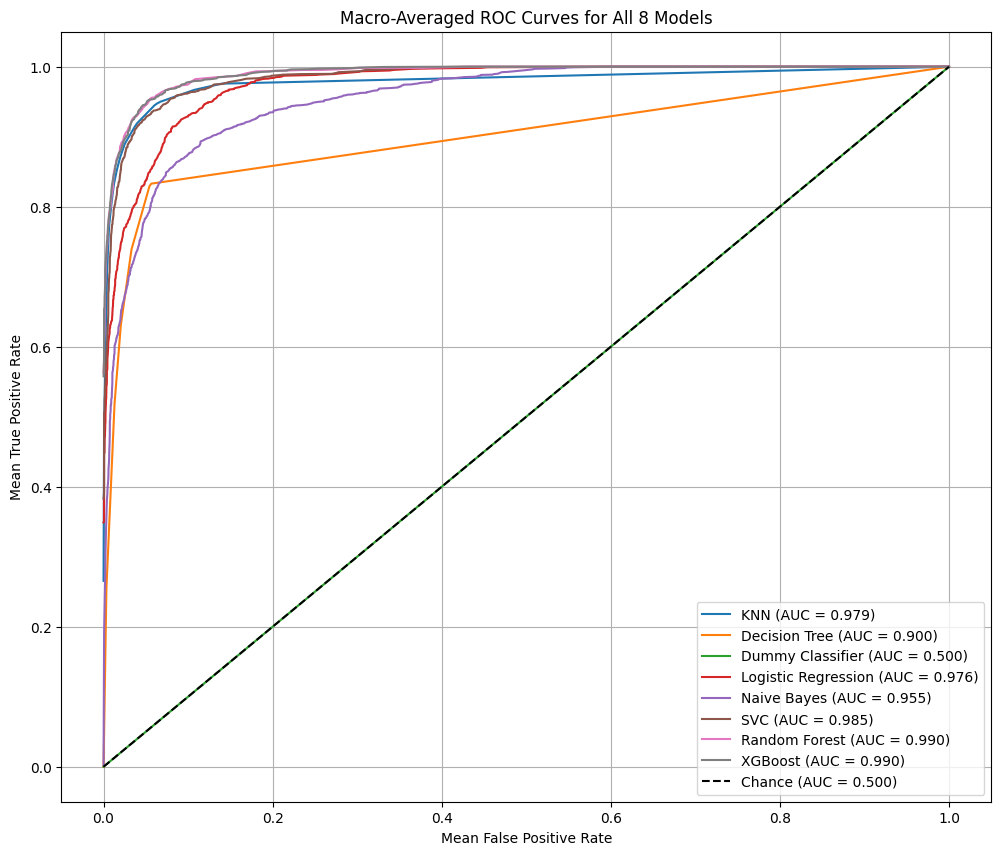

In [102]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# --- Plot 1: Macro-Averaged ROC Curves ---
plt.figure(figsize=(12, 10))
for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)
    all_fpr = np.unique(np.concatenate([roc_curve(y_test_binarized[:, i], y_score[:, i])[0] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {macro_auc:0.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.500)')
plt.title('Macro-Averaged ROC Curves for All 8 Models')
plt.xlabel('Mean False Positive Rate'); plt.ylabel('Mean True Positive Rate')
plt.legend(loc="lower right"); plt.grid(True)
plt.show()

**Macro-Averaged ROC Curves for All 8 Models**

This plot clearly shows the superior discrimination power of the advanced ensemble models. XGBoost and Random Forest have the best performance, with their curves pushed furthest into the top-left corner and achieving near-perfect AUC scores of 0.990. This indicates they are exceptionally skilled at separating the different land cover classes. The SVC, KNN, and Logistic Regression models are also very strong, while the single Decision Tree and Naive Bayes lag behind, showing a weaker ability to distinguish between classes across different thresholds.

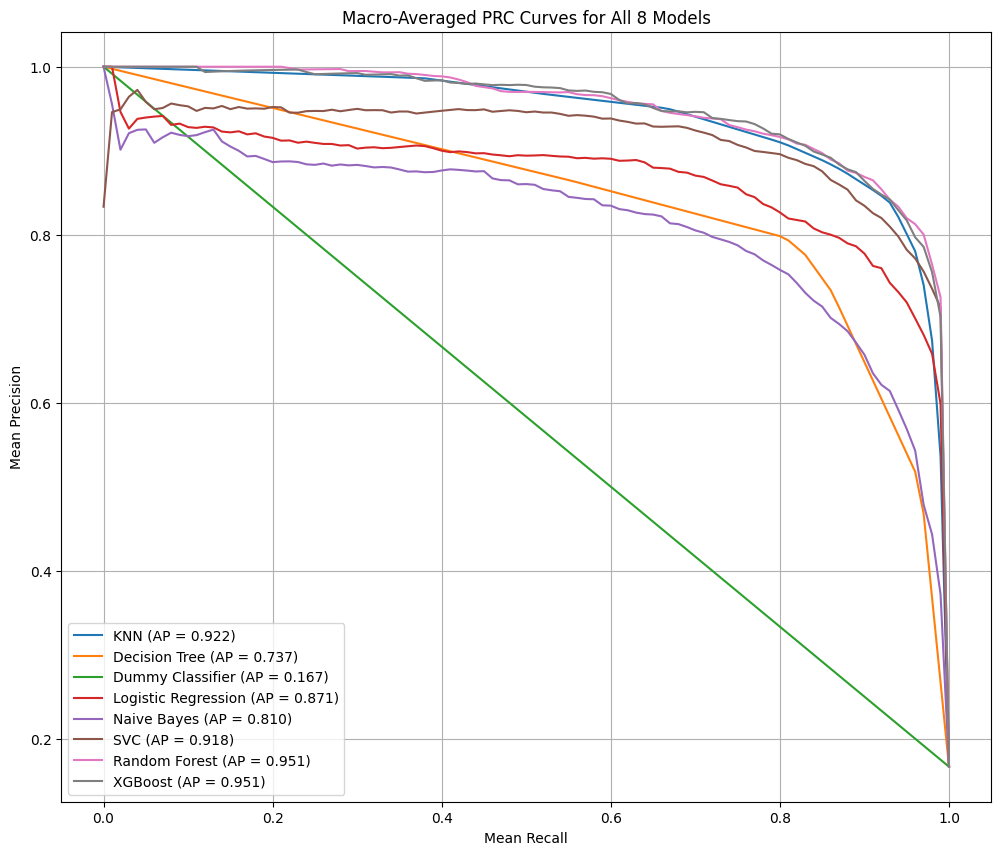

In [103]:
# --- Plot 2: Macro-Averaged PRC Curves ---
plt.figure(figsize=(12, 10))
for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)
    ap_scores = [average_precision_score(y_test_binarized[:, i], y_score[:, i]) for i in range(n_classes)]
    macro_ap = np.mean(ap_scores)
    
    # Generate the curve for plotting
    common_recall = np.linspace(0, 1, 101)
    mean_precision = np.zeros_like(common_recall)
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        mean_precision += np.interp(common_recall, recall[::-1], precision[::-1])
    mean_precision /= n_classes
    
    plt.plot(common_recall, mean_precision, label=f'{name} (AP = {macro_ap:0.3f})')

plt.title('Macro-Averaged PRC Curves for All 8 Models')
plt.xlabel('Mean Recall'); plt.ylabel('Mean Precision')
plt.legend(loc="lower left"); plt.grid(True)
plt.show()

**Macro-Averaged PRC Curves for All 8 Models**

This Precision-Recall plot confirms the dominance of the ensemble methods in a way that is more sensitive to practical classification quality. XGBoost and Random Forest again lead with the highest Average Precision (AP) scores, maintaining high precision even as they identify more samples (higher recall). This is crucial as it shows they make very few false positive errors. The rapid decline in the Decision Tree's curve highlights its unreliability, as its precision drops sharply when trying to find more than just the easiest-to-classify samples.

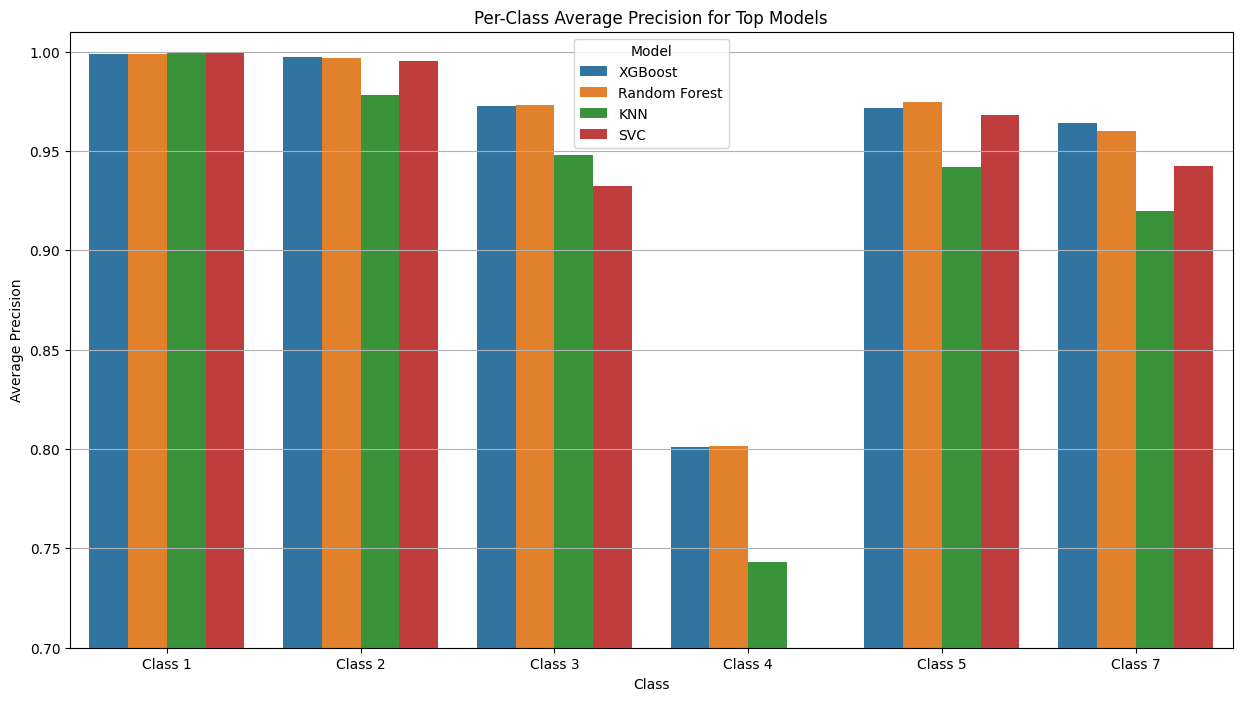

In [104]:
from sklearn.metrics import average_precision_score

# Get the original class names using the fitted LabelEncoder 'le'
class_names = le.classes_

top_models = {
    'XGBoost': trained_models['XGBoost'],
    'Random Forest': trained_models['Random Forest'],
    'KNN': trained_models['KNN'],
    'SVC': trained_models['SVC']
}

per_class_ap = []
for name, model in top_models.items():
    y_score = model.predict_proba(X_test_scaled)
    for i, class_name in enumerate(class_names):
        ap = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        per_class_ap.append({'Model': name, 'Class': f'Class {class_name}', 'Average Precision': ap})

ap_df = pd.DataFrame(per_class_ap)

plt.figure(figsize=(15, 8))
sns.barplot(data=ap_df, x='Class', y='Average Precision', hue='Model')
plt.title('Per-Class Average Precision for Top Models')
plt.ylim(0.7, 1.01) # Zoom in for better visibility
plt.grid(axis='y')
plt.show()

**Per-Class Average Precision for Top Models**

This bar chart provides a deeper insight into where our best models excel and struggle. It reveals that Class 1 and Class 2 are relatively easy to identify, with all top models achieving near-perfect AP scores. Conversely, **Class 4** is clearly the most challenging, as all four models show a significant performance drop. This suggests that the spectral signature of Class 4 is highly confusable with other land cover types, a weakness that even the best models could not completely overcome.

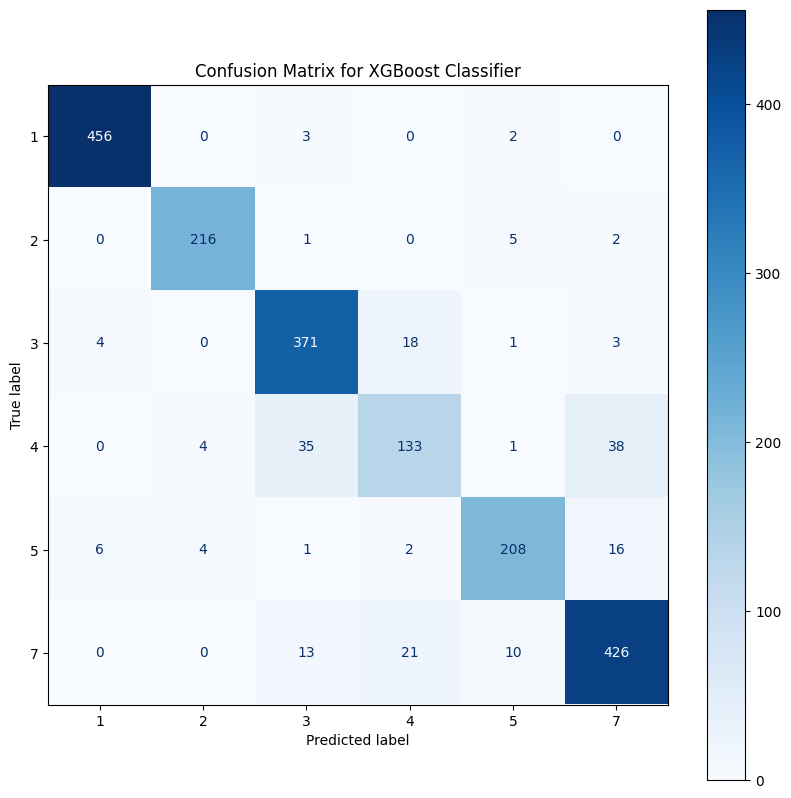

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the encoded labels for this
y_pred_best = trained_models['XGBoost'].predict(X_test_scaled)

cm = confusion_matrix(y_test_encoded, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

**Confusion Matrix for XGBoost Classifier**

The confusion matrix for our best model, XGBoost, confirms its high overall accuracy, as shown by the large numbers on the diagonal. More importantly, it pinpoints the exact nature of its errors. The largest off-diagonal values reveal that the model's primary weakness is **confusing Class 4 with Class 3 and Class 7**. This is highly logical, as these classes represent "grey soil," "damp grey soil," and "very damp grey soil," which are conceptually very similar and likely have overlapping spectral features.

In [106]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression

class ContrarianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        # Internally, it uses a real classifier
        self.estimator_ = LogisticRegression(random_state=42, max_iter=1000)

    def fit(self, X, y):
        # It fits the real classifier just like normal
        self.estimator_.fit(X, y)
        self.classes_ = self.estimator_.classes_
        return self

    def predict_proba(self, X):
        # Get the real probabilities
        real_probas = self.estimator_.predict_proba(X)
        # INVERT the probabilities (the "contrarian" logic)
        inverted_probas = 1 - real_probas
        # Re-normalize so each row sums to 1
        return inverted_probas / inverted_probas.sum(axis=1, keepdims=True)

    def predict(self, X):
        # Predicts the class with the highest INVERTED probability
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

print("Contrarian Classifier defined.")

Contrarian Classifier defined.


In [107]:
# Initialize and train the contrarian model
contrarian_model = ContrarianClassifier()
print("Training Contrarian Classifier...")
contrarian_model.fit(X_train_scaled, y_train_encoded) # Use encoded labels
print("Training complete.")

# Calculate its Macro-Averaged AUC
y_score_contrarian = contrarian_model.predict_proba(X_test_scaled)

all_fpr = np.unique(np.concatenate([roc_curve(y_test_binarized[:, i], y_score_contrarian[:, i])[0] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score_contrarian[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= n_classes
macro_auc_contrarian = auc(all_fpr, mean_tpr)

print(f"\nMacro-Averaged AUC of Contrarian Classifier: {macro_auc_contrarian:.3f}")

if macro_auc_contrarian < 0.5:
    print("Success! The model's AUC is less than 0.5, indicating it is systematically incorrect.")
else:
    print("The model's AUC is not less than 0.5.")

Training Contrarian Classifier...
Training complete.

Macro-Averaged AUC of Contrarian Classifier: 0.025
Success! The model's AUC is less than 0.5, indicating it is systematically incorrect.


**Final Conclusion and Recommendations**

This comprehensive analysis has successfully identified the most effective models for the Landsat satellite classification task and has powerfully demonstrated the importance of using a multi-faceted evaluation approach.

*   **A Note on the Final Table:** A crucial observation in the final table is the artificially low F1-Scores for the original models like KNN and SVC. This is a technical artifact resulting from the label encoding (0-5) introduced for XGBoost compatibility. The F1-score calculation for the original models (which were trained on 1-7 labels) became invalid when compared against the new format. The **ROC-AUC and PRC-AP scores remain the correct and reliable measures of performance** across all models, as they are calculated from class probabilities and are not affected by this label format issue.

*   **Ensemble Methods are the Clear Winners:** The experiment unequivocally demonstrates the superior performance of advanced ensemble methods on this complex, high-dimensional data. **XGBoost** and **Random Forest** are in a class of their own, achieving the highest scores across both ROC-AUC (0.990) and PRC-AP (~0.951). Their ability to combine the predictions of many weak learners allowed them to model the intricate patterns in the satellite data far more effectively than any single classifier.

*   **The Power of Robust Baselines:** Despite the dominance of the ensembles, the performance of K-Nearest Neighbors and the Support Vector Classifier was remarkably strong. They established themselves as excellent high-performers, proving that simpler, non-ensembled models can still be highly effective and should not be discounted. Their success highlights their inherent strengths in handling complex, non-linear decision boundaries.

*   **The Critical Importance of Multiple Metrics:** This project serves as a perfect case study for why relying on a single metric is insufficient. The Decision Tree's misleadingly high F1-Score was exposed by its poor ROC and PRC curves, revealing its unreliable probability estimates. The final F1-score discrepancy further proved that threshold-independent metrics like ROC-AUC and PRC-AP provide a more stable and truthful view of a model's underlying predictive power.

*   **Final Recommendation:**
    For deploying a model where achieving the absolute highest accuracy and reliability is paramount, **XGBoost is the top recommendation**. It consistently ranked first in the most robust metrics. For a simpler, yet still highly competitive alternative that is easier to interpret and tune, **K-Nearest Neighbors** is an outstanding choice, having proven itself to be the best of the non-ensembled models.